#  Predicting Root Causes of Safety Observations

## Predicting Root Causes of Safety Observations using Deep Learning Models

In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
%matplotlib inline

## 1. Importing Data

The data which I am using here is a dump from the Safety Observation System of a Major Company. The each row of data consists of the observation description along with pre-selected category and root cause (Classes). These labelings have been done manually. Thus, we aleady have labels in our dataset.

The objective of this program would be to develop a Deep Learning Model which would be able to predict the EHS Observations based on the historical data. We will try to fit different Deep Learning Models, tuning them for optimal number of input parameters, to arrive at the best model.

By implication this exercise is an Natural Language Processing Exercise, as we will be extracting features from text (Observation Description) and using those for training our clustering model.

The overall plan includes

1. Cleaning the data by removing stops and performing EDA.
2. Feature extraction to arrive on most important features.
3. Feature selection and dimension reduction using Non-Negative Matrix Factorization.
3. Training our different models and measure the performance using pre-identified class labels
4. Evaluation of Models and selection of best model.
5. Summary and Future action.

In [2]:
# let us import the data
df_obs = pd.read_csv('ehs_obs_data.csv')
df_obs.head()

c:\users\aa-minhaj\sklearn-venv\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,UA/UC,Observation,Sub-Category
0,Electrically Unsafe (Safety Hazard),worker used drilling machine without green tag.,NaN
1,Electrically Unsafe (Safety Hazard),Worker used a plug top for multiple electrica...,No Plug top
2,Electrically Unsafe (Safety Hazard),worker use drilling machine at site without gr...,NaN
3,Electrically Unsafe (Safety Hazard),Site supervisor is not available at site whi...,NaN
4,Electrically Unsafe (Safety Hazard),worker use electric grinder without green tag.,No Inspection Done


In [3]:
#Let us check the no of columns and rows

print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 3 and the no of rows is 1028493


The target variable here will be 'Sub-Category' and the input variable will be 'Observation'

## 2. Data Cleaning and Wrangling

In this step we will try to 

1. Bring all words on same case (lower case).
2. Detect the missing values and treat them accordingly.
3. Drop various Stop words which don't add any information to the model.

In [4]:
#Let us first bring in all the required modules

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [5]:
#lets first drop the 'UA/UC' Column which is not required for this exercise.

df_obs.drop('UA/UC', axis = 1, inplace = True)

In [6]:
df_obs.head()

,Observation,Sub-Category
0,worker used drilling machine without green tag.,NaN
1,Worker used a plug top for multiple electrica...,No Plug top
2,worker use drilling machine at site without gr...,NaN
3,Site supervisor is not available at site whi...,NaN
4,worker use electric grinder without green tag.,No Inspection Done


In [7]:
# Lets check the missing values

df_obs.isnull().sum()

Observation     961881
Sub-Category    996100
dtype: int64

Looks like we have lots of blank rows. However, this may be due to faulty data extraction process and we can easily drop these without losing any meaningful information.

In [8]:
# dropping values
df_obs.dropna(subset = ['Observation'], axis = 0, inplace = True)

In [9]:
# Lets check how many values are missing in target variable after dropping missing feature rows
df_obs.shape[0], df_obs.isnull().sum()

(66612,
 Observation         0
 Sub-Category    34219
 dtype: int64)

We can see that we are missing labels for almost half of the data. Now this leaves a lot of room for improvement in data collection and labelling process. Unfortunately, we have to leave out all these rows from our modelling.

In [10]:
#droping values
df_obs.dropna(subset = ['Sub-Category'], axis = 0, inplace = True)
df_obs.shape[0], df_obs.isnull().sum()

(32393,
 Observation     0
 Sub-Category    0
 dtype: int64)

So, in the end we are now left with 32,393 Nos of individual observations

In [11]:
# Lets check for the duplicates in the observation column

df_obs.duplicated(subset = ['Observation'], keep = 'first').sum()

6806

Looks like we have quite a few number of duplicated observation data. It would be better to drop these duplicate columns to avoid any bias in our modelling.

In [12]:
df_obs.drop_duplicates(subset = 'Observation', keep = 'first', ignore_index = True, inplace = True)

In [13]:
# final size of the dataframe
print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 2 and the no of rows is 25587


## Data Cleaning and Wrangling - Summary

* We dropped the null values and duplicated observations to reduce the dimensions of the data
* This also ensures that we avoid assigining higher weightage to certain duplicated observations at the time of feature extraction.
* We also dropped UA/UC columns as we want to explore this dataset purely from NLP perspective.

## 3. Exploratory Data Analysis and Feature Extraction

In this step, we will

1. Remove punctuation marks and anyother extra space.
2. Lemmatize all the words so that different words stemming from same root word are not counted as separate features.
3. Extract features from our observation text using tfidf method.
4. Perform Dimensionality Reduction using NMF

First we will remove the punctuation marks and extra spaces in the string

In [14]:
numbers = map(str, list(range(0, 100)))
for num in numbers:
    df_obs.Observation =  df_obs.Observation.str.replace(num, ' ', regex = False)
special_charecters = ['?', '#', '-', "'", '&', '/', '.', ',', '(', ')', ':',';']
for char in special_charecters:
     df_obs.Observation =  df_obs.Observation.str.replace(char, ' ', regex = False)

In [15]:
df_obs.Observation = df_obs.Observation.apply(lambda x: " ".join(x.split()))
df_obs.Observation = df_obs.Observation.str.strip()

Lets lemmatize our observation text for better results. 

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

We will use WordNetLemmatizer from NTLK library for this purpose

In [16]:
wordlemmatize = WordNetLemmatizer()

In [17]:
def lemmatize_text(word_list):
    lem_word_list = [wordlemmatize.lemmatize(word, pos = 'v') for word in word_list.split()]
    new_lem_word_list = [wordlemmatize.lemmatize(word) for word in lem_word_list]
    return " ".join(new_lem_word_list)

In [18]:
df_obs.Observation = df_obs.Observation.apply(lemmatize_text)

In [19]:
#Lets check our cleaned dataframe

df_obs.sample(10)

,Observation,Sub-Category
2790,weld machine be have metallic body and it be n...,No/ Improper Earthing
12203,CC Debris and excavate material have be keep e...,Excavated soil kept on edge
3893,Bare wire find insert in D B May result in ele...,No Plug top
3951,Portable angle grinder machine be observe with...,Domestic extension/ Electrical Board
23433,Rebar cap have not be provide for the reinforc...,Unprotected rebar edge
8736,MS Pipes lay alignment Ramasamdhram weld pit l...,No/ Improper ladder arrangement
22565,Housekeeping be not complete in CCT room at STP,Poor Housekeeping
10635,soil place on the edge,Excavated soil kept on edge
9021,Visitor find inside plant area without have vi...,Workmen engaged without screening/ Induction
9461,Loose soil keep at the edge of excavate pit,Excavated soil kept on edge


If you watch closely lemmatization has taken affect on many words for ex- against index 7778 the word 'been' has been stemmed to 'be', the word 'kept' has been changed back to 'keep' at 7656. In reality, these words would have been extracted as separate features thereby increasing the overall feature dimension

Now lets encode out target variables to prepare them for modeling

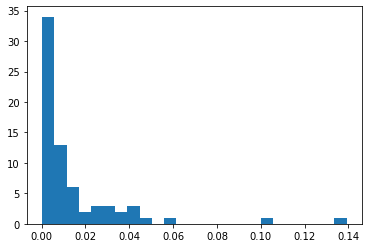

In [23]:
labelencoder = LabelEncoder()
df_obs['Sub-Category'] = labelencoder.fit_transform(df_obs['Sub-Category'])
plt.hist(df_obs['Sub-Category'].value_counts(normalize = True), bins = 25,);

This shows that our classes have quite severe imbalance. And this can impact our final model's performance. Instead of opting for any sampling approach lets try to model our data using imbalanced classes by maintaining class imbalance in the train and test split. We will use class_weight feature wherever available to penalize the imbalance. Also lets save all our label names and codes for future references

In [24]:
label_codes = pd.DataFrame(labelencoder.classes_).reset_index()
label_codes.columns = ['Label Code', 'Label']
label_codes.head()

,Label Code,Label
0,0,No Plug top
1,1,Backhoe Operator engaged without screening and...
2,2,Cable Insulation Issue/Bare Wires ...
3,3,"Cable issues(Routing, Sub-standard etc)"
4,4,Cable/Wire run across accessway


Next and probably most important step for modelling is to extract features from text data. Now there are many methods to acheive this objective but the most important from all is Term Frequency and Inverse Document Frequnecy Method.

In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

Another important term that you will come across would be N-grams. In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles.

Using Latin numerical prefixes, an n-gram of size 1 is referred to as a "unigram"; size 2 is a "bigram" (or, less commonly, a "digram"); size 3 is a "trigram".

For example a feature - 'Safety' is unigram whereas a feature 'Safety Helmet' would be bigram 

In [21]:
# So lets instantiate our tfidfvectorizer by setting feature output for both unigrams and bigrams and Stop words from English
tfidf = TfidfVectorizer(ngram_range = (1,2),
                        stop_words = 'english',
                        min_df = 10,
                       )

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Also, I have set min_df = 10, which means words that occurred in too few documents, in this case less than 10, should be filtered out.

I would higly recommend the reader to go through sklearn's working with text data resources. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

At this point it would be prudent to first split our data into training and test sets and then applying fit_tranform only on the training set using the fit to tranform our test set. 

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_obs.Observation, df_obs['Sub-Category'],
                                                    test_size = 0.3, random_state = 1000,
                                                    stratify = df_obs['Sub-Category']
                                                   )

We have used the stratify attribute in train_test_split. So, the class distribution is maintained in train and test splits. we can move ahead and extract feature using our tfidfvectorizer class instance

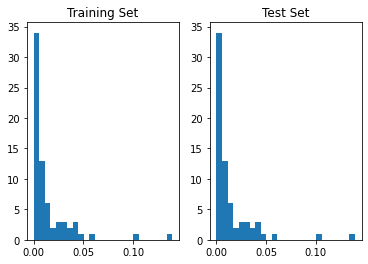

In [26]:
#Lets check the class imbalance in both of train and test splits

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(y_train.value_counts(normalize = True), bins = 25,);
ax1.set(title = 'Training Set');
ax2.hist(y_test.value_counts(normalize = True), bins = 25,);
ax2.set(title = 'Test Set');

In [28]:
features = tfidf.fit_transform(X_train).toarray()

print(f'The feature matrix contains {features.shape[0]} observations with {features.shape[1]} features')

The feature matrix contains 17910 observations with 2582 features


In [29]:
# Let us create the feature matrix for our future reference

feature_matrix = pd.DataFrame(data = features, columns = tfidf.get_feature_names())
feature_matrix.head()

,aaa,absence,access,access approach,access area,access arrangement,access available,access block,access egress,access filter,...,workplace screen,wtp,xi,xi im,yadav,yadav engage,yard,zone,zone area,zone site
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


That's a lot of features and it would be tedious and inefficient to fit all these features to the model. So, it would be better at this stage that to select features that are most important and that can acheive maximum gains for our models.

We will do this in two steps,

* by computing chi-squared stats between each non-negative feature and class.
* Non-negative matrix factorization

Chi2 score can be used to select the features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

In [30]:
from sklearn.feature_selection import chi2

In [31]:
# running chi2 test and storing the chi statistics and p_value

chi2_features, p_value = chi2(feature_matrix, y_train)

In [32]:
# forming the dataframe with features, chi statistics, and p_value

df_chi2_features = pd.DataFrame(data = [feature_matrix.columns, chi2_features, p_value]).T
df_chi2_features.columns = ['Feature_name', 'Chi value', 'p_value']

We form our hyothesis here with the significance level of alpha = 0.05.

Thus our Null hypothesis is that there is no significance association between the input variable and target variable. While our alternate hypothesis is that there is significance association between the input variable and target variable.

Consequently, we will select only those features which have p_value less that 0.05 (Significance level), so that we can reject our null hypothesis.

In [33]:
df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)

,Feature_name,Chi value,p_value
2,access,2632.696183,0.0
898,harness,3083.436262,0.0
925,height pas,2170.761754,0.0
930,helmet,6901.796873,0.0
939,hoe,2082.010137,0.0
...,...,...,...
2124,slab area,89.87553,0.046525
1847,ram nagar,89.862447,0.046616
202,block,89.811884,0.04697
277,cable observe,89.54714,0.048858


Here we can see that we have around 1303 features which are statistically significant thus we can retain them for further modeling. Accordingly, we will drop all other features from our feature matrix.

In [34]:
final_features = df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)
final_feature_columns = list(final_features['Feature_name'])
len(final_feature_columns)

1303

In [35]:
final_feature_matrix = feature_matrix[final_feature_columns].copy()
final_feature_matrix.shape

(17910, 1303)

In [36]:
# transform the test set for future modelling usage

test_set_features = tfidf.transform(X_test).toarray()

In [37]:
test_set_features_matrix = pd.DataFrame(data = test_set_features, columns = tfidf.get_feature_names())
test_set_features_matrix.head()

,aaa,absence,access,access approach,access area,access arrangement,access available,access block,access egress,access filter,...,workplace screen,wtp,xi,xi im,yadav,yadav engage,yard,zone,zone area,zone site
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# applying chi2 test results on test set

test_set_final_features_matrix = test_set_features_matrix[final_feature_columns].copy()
test_set_final_features_matrix.shape

(7677, 1303)

Now, its time to reduce the dimensionality of the feature matrix so that the process of further modelling can be eased and improved.

We will use Non-Negative Matrix Factorization (NMF).

Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

We will reduce dimensions to 5 and 10 components.

In [40]:
# importing NMF library

from sklearn.decomposition import NMF

In [42]:
#Creating the nmf model 1

nmf_model_1 = NMF(n_components = 5, 
                  init = 'random',
                  random_state = 100)

In [46]:
nmf_features_1 = nmf_model_1.fit_transform(final_feature_matrix)

In [47]:
#Creating the nmf model 2

nmf_model_2 = NMF(n_components = 10, 
                  init = 'random',
                  random_state = 100)

In [48]:
nmf_features_2 = nmf_model_2.fit_transform(final_feature_matrix)

In [49]:
nmf_test_features_1 = nmf_model_1.transform(test_set_final_features_matrix)
nmf_test_features_2 = nmf_model_2.transform(test_set_final_features_matrix)

In [35]:
# ## Save the model in pickled form for future reference

# def pickle_model(model, filename):
#     pkl.dump(model, open(filename, 'wb'))
    
# def de_pickle(model):
#     return pkl.load(open(model, 'rb'))

In [39]:
#pickle_model(nmf_features, 'nmf_features_pkl.sav')

In [40]:
#nmf_features = de_pickle('nmf_features_pkl.sav')

In [50]:
print(f'The shape of train set - independent variables using NMF Model 1 {nmf_features_1.shape}')
print(f'The shape of train set - independent variables using NMF Model 2 {nmf_features_2.shape}')
print(f'The shape of test set - independent variables using NMF Model 1 {nmf_test_features_1.shape}')
print(f'The shape of test set - independent variables using NMF Model 2 {nmf_test_features_2.shape}')

The shape of train set - independent variables using NMF Model 1 (17910, 5)
The shape of train set - independent variables using NMF Model 2 (17910, 10)
The shape of test set - independent variables using NMF Model 1 (7677, 5)
The shape of test set - independent variables using NMF Model 2 (7677, 10)


In [51]:
# Lets check the reconstruction error
print(f' The reconstruction error for NMF Model 1 (components = 5) {nmf_model_1.reconstruction_err_}')
print(f' The reconstruction error for NMF Model 2 (components = 10) {nmf_model_2.reconstruction_err_}')

 The reconstruction error for NMF Model 1 (components = 5) 109.76651373126356
 The reconstruction error for NMF Model 2 (components = 10) 107.10156803272466


In [53]:
# Lets visualize them in term of dataframe for NMF Model 1

nmf_features_components_df = pd.DataFrame(nmf_model_1.components_, columns = final_feature_columns)
nmf_features_components_df

,access,harness,height pas,helmet,hoe,housekeep,hydra,hydra operator,id,id card,...,trench safe,unprotected,alignment,chamber barricade,open lead,slab area,ram nagar,block,cable observe,near excavation
0,0.00000,0.020056,0.005811,0.007584,0.023165,0.008859,0.027371,0.02088,0.020289,0.019136,...,0.000000,0.000216,0.000000,0.000000,0.000300,0.000000,0.001469,0.000000,0.000000,0.000800
1,1.09262,0.054026,0.003654,0.004108,0.000248,0.060064,0.000000,0.00000,0.002685,0.001751,...,0.012183,0.005609,0.002824,0.000000,0.001618,0.002840,0.000000,0.031076,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000904,0.001649,0.040636,0.010285,0.00000,0.000000,0.000000,...,0.000000,0.000135,0.002949,0.000000,0.000198,0.000734,0.000476,0.006410,0.012077,0.000000
3,0.00000,0.000000,0.000000,0.001939,0.003264,0.006920,0.000886,0.00000,0.000894,0.000000,...,0.000000,0.001730,0.000441,0.029418,0.002710,0.003308,0.001986,0.002750,0.000000,0.012856
4,0.00000,0.000000,0.000000,0.000140,0.000000,0.035935,0.000254,0.00000,0.000000,0.000000,...,0.005758,0.003416,0.009272,0.000000,0.001668,0.005833,0.002471,0.015676,0.000000,0.041624


In [54]:
# Lets check for each components identified which is the largest contributing featur

column_1 = pd.Series(nmf_features_components_df.idxmax(axis = 1))
column_2 = pd.Series(nmf_features_components_df.max(axis = 1))

largest_component_nmf = pd.concat([column_1, column_2], axis = 1)
largest_component_nmf.columns = ['Feature Names', 'Values']
largest_component_nmf

,Feature Names,Values
0,screen,1.198645
1,access,1.092620
2,electrical,1.101425
3,barricade,1.285637
4,trench,1.060997


In [80]:
num_classes = len(y_train.unique())

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

So the top contributing features to our components look quite rational, indicating that we may proceed ahead with the 70 components.

## Exploratory Data Analysis and Feature Extraction -Summary

* We realised that our data consists of highly imbalanced classes. We tried to take that into consideration by splitting our data using startified option under train_test_split function.
* This ensured that we maintained the equal amount of imbalance in our test as well as train split.
* Next step was to prepare the text data for further feature extraction. We applied various transformations such as lemmatization amd acheiving homogenization by converting all words into lower case.
* We encoded our target variables.
* Finally, we used tfidfvectorizer to extract features from our text data. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.
* As usual we fitted and transformed tfidfvectorizer over train data and used that fiited model to transform our test data.
* We performed chi2 test to extract the best associated features with p-value less than 0.05.
* Finally we used NMF method to decompose our features into 5 and 10 Components

## 4. Model Evaluation and Selection

In this step, we will,

1. Select the best model and subsequently the best values for model parameters.
2. Also, we will try to reach best compromise over the precision and recall values.

In [67]:
# let us import all the required modules

## Import Keras objects for Deep Learning
from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

#### Model 1 (5 Components)

In [100]:
# Define the Model 
# Input size is 5-dimensional
# 1 hidden layer, 12 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

model_1 = Sequential()
model_1.add(Dense(1000,input_shape = (5,),activation = 'relu'))
model_1.add(Dropout(0.25, seed = 1000))
model_1.add(Dense(1000,activation = 'relu'))
model_1.add(Dropout(0.25, seed = 500))
model_1.add(Dense(70,activation='softmax'))

In [101]:
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1000)              6000      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 70)                70070     
Total params: 1,077,070
Trainable params: 1,077,070
Non-trainable params: 0
_________________________________________________________________


In [102]:
model_1.compile(SGD(learning_rate = .003), 
                loss='categorical_crossentropy', 
                metrics=['AUC','accuracy'])
run_hist_1 = model_1.fit(nmf_features_1, y_train, 
                         validation_data=(nmf_test_features_1, y_test), 
                         batch_size = 30,
                         epochs=200)

Epoch 1/200
597/597 [==============================] - 7s 10ms/step - loss: 4.1808 - auc: 0.6491 - accuracy: 0.1429 - val_loss: 4.1081 - val_auc: 0.7437 - val_accuracy: 0.1391
Epoch 2/200
597/597 [==============================] - 6s 9ms/step - loss: 4.0300 - auc: 0.7548 - accuracy: 0.1392 - val_loss: 3.9407 - val_auc: 0.7702 - val_accuracy: 0.1391
Epoch 3/200
597/597 [==============================] - 6s 10ms/step - loss: 3.8469 - auc: 0.7709 - accuracy: 0.1392 - val_loss: 3.7478 - val_auc: 0.7757 - val_accuracy: 0.1391
Epoch 4/200
597/597 [==============================] - 6s 10ms/step - loss: 3.6814 - auc: 0.7999 - accuracy: 0.1392 - val_loss: 3.6206 - val_auc: 0.8043 - val_accuracy: 0.1391
Epoch 5/200
597/597 [==============================] - 6s 9ms/step - loss: 3.5892 - auc: 0.7975 - accuracy: 0.1392 - val_loss: 3.5526 - val_auc: 0.7974 - val_accuracy: 0.1391
Epoch 6/200
597/597 [==============================] - 6s 10ms/step - loss: 3.5355 - auc: 0.8000 - accuracy: 0.1400 - val_

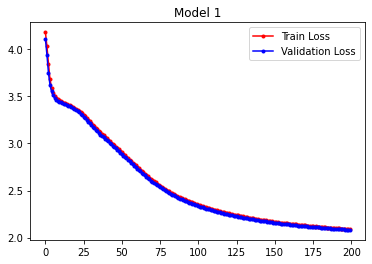

In [227]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title('Model 1')
ax.legend();

Here, we can see that the both model train loss and validation loss have plataeued, indicating either we need to increase the epochs, learning rate or otherwise we have reached the optimal loss level.

#### Model 2 (10 Components)

In [106]:
model_2 = Sequential()
model_2.add(Dense(1000,input_shape = (10,),activation = 'relu'))
model_2.add(Dropout(0.25, seed = 1000))
model_2.add(Dense(1000,activation = 'relu'))
model_2.add(Dropout(0.25, seed = 500))
model_2.add(Dense(70,activation='softmax'))

In [107]:
model_2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1000)              11000     
_________________________________________________________________
dropout_24 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 70)                70070     
Total params: 1,082,070
Trainable params: 1,082,070
Non-trainable params: 0
_________________________________________________________________


In [109]:
model_2.compile(SGD(learning_rate = .003), 
                loss='categorical_crossentropy', 
                metrics=['AUC','accuracy'])
run_hist_2 = model_2.fit(nmf_features_2, y_train, 
                         validation_data=(nmf_test_features_2, y_test), 
                         batch_size = 30,
                         epochs=200)

Epoch 1/200
597/597 [==============================] - 5s 7ms/step - loss: 4.1804 - auc: 0.6530 - accuracy: 0.1416 - val_loss: 4.1068 - val_auc: 0.7364 - val_accuracy: 0.1391
Epoch 2/200
597/597 [==============================] - 4s 7ms/step - loss: 4.0254 - auc: 0.7473 - accuracy: 0.1392 - val_loss: 3.9317 - val_auc: 0.7519 - val_accuracy: 0.1391
Epoch 3/200
597/597 [==============================] - 5s 8ms/step - loss: 3.8325 - auc: 0.7621 - accuracy: 0.1392 - val_loss: 3.7306 - val_auc: 0.7859 - val_accuracy: 0.1391
Epoch 4/200
597/597 [==============================] - 4s 7ms/step - loss: 3.6657 - auc: 0.8028 - accuracy: 0.1392 - val_loss: 3.6060 - val_auc: 0.8089 - val_accuracy: 0.1391
Epoch 5/200
597/597 [==============================] - 4s 7ms/step - loss: 3.5730 - auc: 0.8039 - accuracy: 0.1396 - val_loss: 3.5358 - val_auc: 0.8015 - val_accuracy: 0.1391
Epoch 6/200
597/597 [==============================] - 5s 8ms/step - loss: 3.5179 - auc: 0.8095 - accuracy: 0.1413 - val_loss

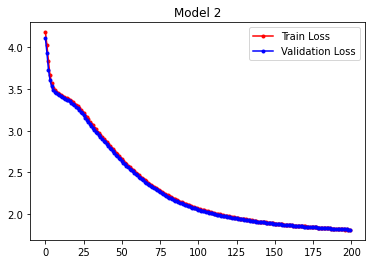

In [228]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_2.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title('Model 2')
ax.legend();

Once again we can see that the loss reduction is painfully slow, so we may need to increase learning rate or epoch.

In [116]:
final_feature_matrix_array = final_feature_matrix.values
final_feature_matrix_array.shape

(17910, 1303)

In [119]:
test_set_final_features_matrix_array = test_set_final_features_matrix.values
test_set_final_features_matrix_array.shape

(7677, 1303)

#### Model 3 (1303 Components)

In [117]:
model_3 = Sequential()
model_3.add(Dense(1000,input_shape = (1303,),activation = 'relu'))
model_3.add(Dropout(0.25, seed = 1000))
model_3.add(Dense(1000,activation = 'relu'))
model_3.add(Dropout(0.25, seed = 500))
model_3.add(Dense(70,activation='softmax'))

In [118]:
model_3.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1000)              1304000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_27 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 70)                70070     
Total params: 2,375,070
Trainable params: 2,375,070
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_3.compile(SGD(learning_rate = .003), 
                loss='categorical_crossentropy', 
                metrics=['AUC','accuracy'])
run_hist_3 = model_3.fit(final_feature_matrix_array, y_train, 
                         validation_data=(test_set_final_features_matrix_array, y_test), 
                         batch_size = 30,
                         epochs=200)

Epoch 1/200
597/597 [==============================] - 9s 14ms/step - loss: 4.1858 - auc: 0.6492 - accuracy: 0.1199 - val_loss: 4.1172 - val_auc: 0.7449 - val_accuracy: 0.1391
Epoch 2/200
597/597 [==============================] - 8s 13ms/step - loss: 4.0353 - auc: 0.7578 - accuracy: 0.1392 - val_loss: 3.9414 - val_auc: 0.7668 - val_accuracy: 0.1391
Epoch 3/200
597/597 [==============================] - 8s 13ms/step - loss: 3.8346 - auc: 0.7760 - accuracy: 0.1392 - val_loss: 3.7260 - val_auc: 0.7973 - val_accuracy: 0.1391
Epoch 4/200
597/597 [==============================] - 8s 13ms/step - loss: 3.6501 - auc: 0.8064 - accuracy: 0.1392 - val_loss: 3.5877 - val_auc: 0.8077 - val_accuracy: 0.1391
Epoch 5/200
597/597 [==============================] - 7s 11ms/step - loss: 3.5515 - auc: 0.8026 - accuracy: 0.1393 - val_loss: 3.5124 - val_auc: 0.8043 - val_accuracy: 0.1391
Epoch 6/200
597/597 [==============================] - 7s 11ms/step - loss: 3.4921 - auc: 0.8119 - accuracy: 0.1410 - va

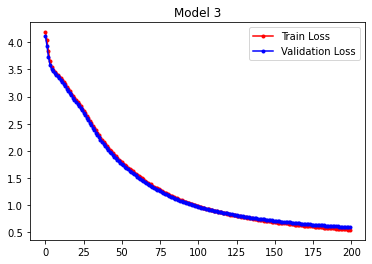

In [229]:
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_3.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title('Model 3')
ax.legend();

So, in this model we actually started seeing a deviation in train and validation loss, which probably means we have acheived optimal modelling performance.

Let us create a small function to generate a dataframe for comparing all three models

In [121]:
y_pred_model_1 = model_1.predict(nmf_test_features_1)>0.5
y_pred_model_1_prob = model_1.predict(nmf_test_features_1)

y_pred_model_2 = model_2.predict(nmf_test_features_2)>0.5
y_pred_model_2_prob = model_2.predict(nmf_test_features_2)

y_pred_model_3 = model_3.predict(test_set_final_features_matrix_array)>0.5
y_pred_model_3_prob = model_3.predict(test_set_final_features_matrix_array)

In [167]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, \
roc_curve, accuracy_score, classification_report

In [213]:
def model_report(model, y_true, y_pred, label_encoder):
    ML_model = pd.DataFrame(classification_report(y_test, y_pred,
                                                  output_dict = True, 
                                                  target_names = list(label_encoder.classes_),
                                                  zero_division= 0
                                                 )).T
    level0 = pd.MultiIndex.from_product([[model], ML_model.columns])
    ML_model.columns = level0
    return ML_model.tail(4)

In [215]:
NN_model_1 = model_report('NN Model 1 (n_components = 5)', y_test, y_pred_model_1, labelencoder)
NN_model_2 = model_report('NN Model 2 (n_components = 10)', y_test, y_pred_model_2, labelencoder)
NN_model_3 = model_report('NN Model 3 (n_components = 1303)', y_test, y_pred_model_3, labelencoder)

In [216]:
comparision_table = pd.concat([NN_model_1, NN_model_2, NN_model_3], axis = 1)

In [217]:
comparision_table

NN Model 1 (n_components = 5)                              \
                                 precision    recall  f1-score support   
micro avg                         0.704947  0.259867  0.379747  7677.0   
macro avg                         0.050067  0.044537  0.044189  7677.0   
weighted avg                      0.262660  0.259867  0.251446  7677.0   
samples avg                       0.259867  0.259867  0.259867  7677.0   

             NN Model 2 (n_components = 10)                              \
                                  precision    recall  f1-score support   
micro avg                          0.691323  0.351830  0.466333  7677.0   
macro avg                          0.098482  0.079131  0.082222  7677.0   
weighted avg                       0.380102  0.351830  0.351640  7677.0   
samples avg                        0.351830  0.351830  0.351830  7677.0   

             NN Model 3 (n_components = 1303)                              
                                    precision    recall  f1-score support  
micro avg                            0.889822  0.773219  0.827432  7677.0  
macro avg                            0.555545  0.426130  0.463574  7677.0  
weighted avg                         0.850100  0.773219  0.794048  7677.0  
samples avg                          0.773219  0.773219  0.773219  7677.0

## Model Evaluation and Selection - Summary

We tried to train 3 models,
>1. Model 1 (n_components = 5) 
>2. Model 2 (n_compenents = 10)
>3. Model 3 (n_compoenents = 1303)

We set forth our expectations clearly,
>1. High Precision and Recall
>2. Higher micro average f1-score.

Both of which were met by Model 3 with 1303 components (input features). The model had micro precison, recall and f1 score of 0.889, 0.773 and 0.827 respectively

In general, Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In our case, class imbalance is definitely present and a high micro average definitely preferred, which our model acheives.

As explained earlier, there is huge imbalance in dataset and trying to classify each minority class correctly may lead to overfitting. Thus it would be better to avoid false alarms by opting for better precision. Additionally, correct prediction of majority class was must; let me explain in details

>Almost all safety systems are based on basic philosphy of identifying the root causes and correcting them. This means that if you have truly identified a root cause and treated it appropiately, there would be no repition of similar observation. This is of course an ideal situation. However, in real life these incidents may stll recur and it may not be possible to completely eliminate them due to various factors. Thus the next best measure which is adopted by most organisations is counting repetition of root causes. Higher the count more serious the issue and thus more immediate action required. This frequency is then multiplied with probable consequence to get the actual risk of incident. However, this model is concerned with only getting the frequency right.

<P>Thus, it make sense to identify majority classes with higher precision and recall, hence the chose of measure - Micro F1 Score for selecting best estimator.

## 5. Conclusion and Future Directions

In conclusion, we chose Model 3 for purpose of deployment for future predictions. The model not only shows great prediction power, it gives lower false positives at the same time has higher micro average f1-score, precision and recall.

Going further, in future we may improve our modelling performance by,

* Oversampling or Undersampling, or combining both to check whether we can acheive better classification.
* At the time of feature extraction we only used unigrams and bigrams, we can also use further higher degree of feature such as trigram (combination of three words)
* While training models with lesser components, the accuracy achieved was very poor. Additionally, the change or decrease in losses was very slow. Thus we may try increasing the learning rate to check where actually we acheive optimal results for Model 1 (5 components) and Model 2 (10 components).
* We may also try to increase the number of epochs parallelly to check the convergence.
* The Error metrics used for fitting were AUC and Accuracy. We may try other metrics; refer - https://www.tensorflow.org/api_docs/python/tf/keras/metrics
* Finally we can actaully re-work on our input data to maybe eliminate some of the labels by combining with other similar labels, thus reducing some granularity in data when not required.

## Thank You, for visiting my page and going through this notebook.

# CIAO !!